In [93]:
from google.colab import files
uploaded = files.upload()

Saving table_schema.yaml to table_schema (5).yaml


In [94]:
import yaml

# Use the actual filename you uploaded (typically same as the original)
with open("table_schema (5).yaml", "r", encoding="utf-8") as f:
    meta_dict = yaml.safe_load(f)

In [95]:
import yaml
from pprint import pprint  # For nice nested structure

# Print structure
pprint(meta_dict)

{'tables': {'all_star': {'aliases': ['asg',
                                     'allstar',
                                     'all_star_game',
                                     'allstars'],
                         'description': 'Details the records of baseball '
                                        'players selected as All-Stars in '
                                        'various years and their participation '
                                        'in All-Star games.',
                         'foreign_keys': [{'column': 'player_id',
                                           'ref_column': 'player_id',
                                           'ref_table': 'player'},
                                          {'column': 'team_id',
                                           'ref_column': 'team_id',
                                           'ref_table': 'team'},
                                          {'column': 'league_id',
                                           '

In [103]:
def extract_table_embedding_info(meta_dict):
    """
    Given a schema metadata dictionary with a 'tables' key,
    extract info for table-level embeddings.
    Returns a list of dicts (one per table) with canonical name, description,
    synonyms, aliases, and tags as a joined embedding text.
    """
    table_embedding_items = []
    for table, meta in meta_dict['tables'].items():  # <-- Fix is here!
        desc = meta.get('description', '')
        synonyms = meta.get('synonyms', [])
        aliases = meta.get('aliases', [])
        tags = meta.get('tags', [])
        # Create a single string for embedding
        embedding_text = (
            f"Table: {table}. "
            f"Description: {desc}. "
            f"Synonyms: {', '.join(synonyms)}. "
            f"Aliases: {', '.join(aliases)}. "
            f"Tags: {', '.join(tags)}."
        )
        table_embedding_items.append({
            'table': table,
            'description': desc,
            'synonyms': synonyms,
            'aliases': aliases,
            'tags': tags,
            'embedding_text': embedding_text
        })
    return table_embedding_items

# Example usage:
table_info_list = extract_table_embedding_info(meta_dict)
for t in table_info_list:
    print(t['embedding_text'])
print("Number of tables:", len(table_info_list))  # This will print the table count


Table: all_star. Description: Details the records of baseball players selected as All-Stars in various years and their participation in All-Star games.. Synonyms: All-Star records, All-Star appearances, All-Star game participants. Aliases: asg, allstar, all_star_game, allstars. Tags: baseball, All-Star game, sports, player participation.
Table: appearances. Description: Player participation in various positions for each game and season. Contains stats like games played in each fielding position, for every player-year-team.. Synonyms: player appearances, fielding appearances, games played. Aliases: apps, games_played, appear. Tags: baseball, fielding, player participation.
Table: manager_award. Description: Records the various awards given to baseball managers for different leagues and years.. Synonyms: manager honors, coaching awards, managerial accolades. Aliases: mgr_award, coach_award. Tags: baseball, awards, managers.
Table: player_award. Description: Information about awards recei

In [101]:
import networkx as nx

def build_schema_graph(meta_dict):
    G = nx.DiGraph()
    for table, meta in meta_dict['tables'].items():
        G.add_node(table)
        for fk in meta.get('foreign_keys', []):
            ref_table = fk['ref_table']
            # Add edge FROM this table TO the referenced table
            G.add_edge(table, ref_table, column=fk['column'], ref_column=fk['ref_column'])
    return G

# Usage
G = build_schema_graph(meta_dict)
print("Tables in graph:", G.nodes)
print("Edges (FKs):", G.edges(data=True))
print("Number of tables (nodes):", G.number_of_nodes())
print("Number of foreign key edges:", G.number_of_edges())
print("List of tables (nodes):", list(G.nodes))
print("List of foreign key edges:", list(G.edges(data=True)))

Tables in graph: ['all_star', 'player', 'team', 'appearances', 'manager_award', 'manager', 'player_award', 'manager_award_vote', 'player_award_vote', 'batting', 'batting_postseason', 'player_college', 'college', 'fielding', 'fielding_outfield', 'fielding_postseason', 'hall_of_fame', 'home_game', 'park', 'manager_half', 'pitching', 'pitching_postseason', 'salary', 'postseason', 'league', 'team_franchise', 'team_half']
Edges (FKs): [('all_star', 'player', {'column': 'player_id', 'ref_column': 'player_id'}), ('all_star', 'team', {'column': 'league_id', 'ref_column': 'league_id'}), ('team', 'league', {'column': 'league_id', 'ref_column': 'league_id'}), ('team', 'team_franchise', {'column': 'franchise_id', 'ref_column': 'franchise_id'}), ('appearances', 'player', {'column': 'player_id', 'ref_column': 'player_id'}), ('appearances', 'team', {'column': 'league_id', 'ref_column': 'league_id'}), ('manager_award', 'manager', {'column': 'manager_id', 'ref_column': 'manager_id'}), ('manager_award',

In [98]:
# ---------- Configuration ----------
from openai import OpenAI
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_KEY')
 #---------- Client Setup ----------
client = OpenAI(api_key=OPENAI_API_KEY)

In [107]:
import openai

# If using OpenAI v1.x (latest as of 2024)
def get_openai_embeddings(texts, client, model="text-embedding-3-large", batch_size=20, show_progress=True):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        try:
            # This is the correct API call
            response = client.embeddings.create(
                input=batch,
                model=model
            )
            batch_embeddings = [d.embedding for d in response.data]
            embeddings.extend(batch_embeddings)
            if show_progress:
                print(f"✅ Embedded [{i+1}-{i+len(batch)}] of {len(texts)}")
        except Exception as e:
            print(f"❌ Batch {i+1}-{i+len(batch)} failed: {e}")
    import numpy as np
    return np.array(embeddings)


In [104]:
embedding_texts = [t['embedding_text'] for t in table_info_list]
print("Number of embedding texts:", len(embedding_texts))
for i, text in enumerate(embedding_texts):
    print(f"{i+1}: {text[:80]}...")  # Preview first 80 chars of each

Number of embedding texts: 27
1: Table: all_star. Description: Details the records of baseball players selected a...
2: Table: appearances. Description: Player participation in various positions for e...
3: Table: manager_award. Description: Records the various awards given to baseball ...
4: Table: player_award. Description: Information about awards received by baseball ...
5: Table: manager_award_vote. Description: Voting results for baseball managerial a...
6: Table: player_award_vote. Description: Records the voting results for baseball a...
7: Table: batting. Description: Historical batting statistics for baseball players,...
8: Table: batting_postseason. Description: Postseason batting statistics for baseba...
9: Table: player_college. Description: Correlates baseball players with the college...
10: Table: fielding. Description: Fielding statistics for baseball players, covering...
11: Table: fielding_outfield. Description: Fielding appearances of outfield players ...
12: Table: 

In [108]:
# --- Usage Example ---
embeddings = get_openai_embeddings(
    embedding_texts,         # your list of texts
    client,                  # your OpenAI client object
    model="text-embedding-3-large",
    batch_size=20,
    show_progress=True
)
print(embeddings.shape)


✅ Embedded [1-20] of 27
✅ Embedded [21-27] of 27
(27, 3072)


In [109]:
complex_samples = [
    {
        "question": "List players who received salary in both 2005 and 2007.",
        "gold_sql": """SELECT name_first, name_last
FROM player
JOIN salary ON player.player_id = salary.player_id
WHERE year = 2005
INTERSECT
SELECT name_first, name_last
FROM player
JOIN salary ON player.player_id = salary.player_id
WHERE year = 2007;"""
    },
    {
        "question": "Get player names who were inducted into the Hall of Fame and also received an award.",
        "gold_sql": """SELECT player.name_first, player.name_last
FROM player
JOIN hall_of_fame ON player.player_id = hall_of_fame.player_id
INTERSECT
SELECT player.name_first, player.name_last
FROM player
JOIN player_award ON player.player_id = player_award.player_id;"""
    },
    {
        "question": "Show all players who played for 'Yankees' and were born after 1980.",
        "gold_sql": """SELECT DISTINCT player.name_first, player.name_last
FROM player
JOIN appearances ON player.player_id = appearances.player_id
WHERE appearances.team_id = 'NYA' AND CAST(player.birth_year AS INTEGER) > 1980;"""
    },
    {
        "question": "Which players have played as both catcher and pitcher?",
        "gold_sql": """SELECT player_id
FROM appearances
WHERE g_c > 0
INTERSECT
SELECT player_id
FROM appearances
WHERE g_p > 0;"""
    },
    {
        "question": "Which players were active in both regular and postseason games in the same year?",
        "gold_sql": """SELECT player_id
FROM batting
WHERE year = 2000
INTERSECT
SELECT player_id
FROM batting_postseason
WHERE year = 2000;"""
    }
]


In [110]:
# 1. Extract all table info for embeddings/searching
table_info_list = extract_table_embedding_info(meta_dict)
table_names = [x['table'] for x in table_info_list]
embedding_texts = [x['embedding_text'] for x in table_info_list]

# 2. Create embeddings for all tables (description+synonyms+tags)
embeddings = get_openai_embeddings(embedding_texts, client=client)

print("embedding_texts:", len(embedding_texts))
print("embeddings:", embeddings.shape)
print("table_names:", len(table_names))

# Quick sanity check:
assert embeddings.shape[0] == len(table_names) == len(embedding_texts), "Mismatch in table/embedding counts!"


✅ Embedded [1-20] of 27
✅ Embedded [21-27] of 27
embedding_texts: 27
embeddings: (27, 3072)
table_names: 27


In [111]:
import numpy as np

# --- Your embedding function (ensure this version is used) ---
def get_openai_embeddings(texts, client, model="text-embedding-3-small"):
    batch_size = 20
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        resp = client.embeddings.create(input=batch, model=model)
        batch_embeds = [d.embedding for d in resp.data]
        embeddings.extend(batch_embeds)
    return np.array(embeddings)

# --- Table embedding extraction from meta_dict ---
def extract_table_embedding_info(meta_dict):
    table_embedding_items = []
    for table, meta in meta_dict['tables'].items():
        desc = meta.get('description', '')
        synonyms = meta.get('synonyms', [])
        aliases = meta.get('aliases', [])
        tags = meta.get('tags', [])
        embedding_text = (
            f"Table: {table}. "
            f"Description: {desc}. "
            f"Synonyms: {', '.join(synonyms)}. "
            f"Aliases: {', '.join(aliases)}. "
            f"Tags: {', '.join(tags)}."
        )
        table_embedding_items.append({
            'table': table,
            'description': desc,
            'synonyms': synonyms,
            'aliases': aliases,
            'tags': tags,
            'embedding_text': embedding_text
        })
    return table_embedding_items

# --- Semantic table retrieval ---
def retrieve_tables_from_nlq(nlq, embeddings, table_names, embed_fn, client, top_n=5):
    nlq_emb = embed_fn([nlq], client=client)[0]
    sims = np.dot(embeddings, nlq_emb) / (np.linalg.norm(embeddings, axis=1) * np.linalg.norm(nlq_emb))
    top_indices = np.argsort(sims)[-top_n:][::-1]
    result = [(table_names[i], sims[i]) for i in top_indices]
    return result

# --- Pipeline Start ---
# Step 1: Build table embeddings
table_info_list = extract_table_embedding_info(meta_dict)
table_names = [x['table'] for x in table_info_list]
embedding_texts = [x['embedding_text'] for x in table_info_list]

embeddings = get_openai_embeddings(embedding_texts, client=client)
print("embedding_texts:", len(embedding_texts))
print("embeddings:", embeddings.shape)
print("table_names:", len(table_names))

# Step 2: Retrieve relevant tables for each NLQ
for idx, sample in enumerate(complex_samples):
    nlq = sample["question"]
    top_tables = retrieve_tables_from_nlq(
        nlq,
        embeddings,
        table_names,
        embed_fn=get_openai_embeddings,  # Pass the function
        client=client,                   # Pass your OpenAI client
        top_n=5
    )
    print(f"\n=== Example {idx+1} ===")
    print("NLQ:", nlq)
    print("Top tables (by semantic similarity):")
    for tname, score in top_tables:
        print(f"  - {tname} (score={score:.3f})")


embedding_texts: 27
embeddings: (27, 1536)
table_names: 27

=== Example 1 ===
NLQ: List players who received salary in both 2005 and 2007.
Top tables (by semantic similarity):
  - salary (score=0.410)
  - player_college (score=0.334)
  - player_award (score=0.324)
  - appearances (score=0.308)
  - all_star (score=0.308)

=== Example 2 ===
NLQ: Get player names who were inducted into the Hall of Fame and also received an award.
Top tables (by semantic similarity):
  - hall_of_fame (score=0.592)
  - player_award (score=0.534)
  - player_award_vote (score=0.460)
  - manager_award (score=0.398)
  - all_star (score=0.395)

=== Example 3 ===
NLQ: Show all players who played for 'Yankees' and were born after 1980.
Top tables (by semantic similarity):
  - all_star (score=0.402)
  - player_college (score=0.399)
  - player (score=0.396)
  - appearances (score=0.366)
  - player_award (score=0.348)

=== Example 4 ===
NLQ: Which players have played as both catcher and pitcher?
Top tables (by semant

In [60]:
def expand_tables_graph(G, tables, hops=1):
    expanded = set(tables)
    UG = G.to_undirected()
    for table in tables:
        nodes = nx.single_source_shortest_path_length(UG, table, cutoff=hops).keys()
        expanded.update(nodes)
    return expanded


In [44]:
for idx, sample in enumerate(complex_samples):
    nlq = sample["question"]
    top_tables = retrieve_tables_from_nlq(
        nlq,
        embeddings,
        table_names,
        embed_fn=get_openai_embeddings,
        client=client,
        top_n=5
    )
    initial_tables = [t[0] for t in top_tables]  # just the names
    expanded_tables = expand_tables_graph(G, initial_tables, hops=1)
    print(f"\n=== Example {idx+1} ===")
    print("NLQ:", nlq)
    print("Initial tables (by semantic similarity):", initial_tables)
    print("Expanded tables (after 1-hop graph):", sorted(expanded_tables))



=== Example 1 ===
NLQ: List players who received salary in both 2005 and 2007.
Initial tables (by semantic similarity): ['salary', 'player_college', 'player_award', 'appearances', 'all_star']
Expanded tables (after 1-hop graph): ['all_star', 'appearances', 'college', 'player', 'player_award', 'player_college', 'salary', 'team']

=== Example 2 ===
NLQ: Get player names who were inducted into the Hall of Fame and also received an award.
Initial tables (by semantic similarity): ['hall_of_fame', 'player_award', 'player_award_vote', 'manager_award', 'all_star']
Expanded tables (after 1-hop graph): ['all_star', 'hall_of_fame', 'manager', 'manager_award', 'player', 'player_award', 'player_award_vote', 'team']

=== Example 3 ===
NLQ: Show all players who played for 'Yankees' and were born after 1980.
Initial tables (by semantic similarity): ['player_college', 'all_star', 'player', 'appearances', 'player_award']
Expanded tables (after 1-hop graph): ['all_star', 'appearances', 'batting', 'batti

In [112]:
import openai

def build_table_block(table, meta):
    block = f"Table: {table}\n"
    block += f"Description: {meta.get('description', '')}\n"
    block += f"Synonyms: {', '.join(meta.get('synonyms', []))}\n"
    block += f"Aliases: {', '.join(meta.get('aliases', []))}\n"
    block += f"Tags: {', '.join(meta.get('tags', []))}\n"
    if 'instructions' in meta:
        block += f"Instructions: {meta['instructions']}\n"
    if 'foreign_keys' in meta and meta['foreign_keys']:
        fks = []
        for fk in meta['foreign_keys']:
            fks.append(f"{fk['column']} → {fk['ref_table']}.{fk['ref_column']}")
        block += f"Foreign Keys: {', '.join(fks)}\n"
    return block

def call_llm_table_selection(prompt, client=None, model="gpt-4o", max_tokens=512):
    """Send the prompt to an LLM and return the response text."""
    if client is None:
        import openai
        client = openai.OpenAI()  # Or openai.Client() depending on your SDK version
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are an expert in SQL, databases, and schema design. Given a set of tables and a user question, select the minimal relevant tables required to answer the question, and explain your rationale. Output tables as a list."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=max_tokens,
        temperature=0.0
    )
    return response.choices[0].message.content.strip()

# --- Main loop: for each NLQ, show context, then call LLM for final selection ---
for idx, sample in enumerate(complex_samples):
    nlq = sample["question"]
    top_tables = retrieve_tables_from_nlq(
        nlq,
        embeddings,
        table_names,
        embed_fn=get_openai_embeddings,
        client=client,
        top_n=5
    )
    initial_tables = [t[0] for t in top_tables]
    expanded_tables = sorted(expand_tables_graph(G, initial_tables, hops=1))

    # Gather all metadata blocks for prompt
    all_tables = sorted(set(initial_tables + expanded_tables))
    prompt_tables_block = ""
    for t in all_tables:
        prompt_tables_block += build_table_block(t, meta_dict['tables'][t]) + "\n"

    # Compose the final prompt
    prompt = f"""
Given the following set of database tables (with their descriptions, synonyms, aliases, tags, instructions, and relationships):

{prompt_tables_block}

User Question: "{nlq}"

Identify the minimal and most relevant set of tables required to answer this question. Explain your reasoning. Output only the list of required tables and a short explanation.
"""

    print(f"\n=== Example {idx+1} ===")
    print("NLQ:", nlq)
    print("Initial tables (by semantic similarity):", initial_tables)
    print("Expanded tables (after 1-hop graph):", expanded_tables)
    print("\n--- Tables Context Block for LLM Prompt ---\n")
    print(prompt)
    print("\n--- LLM Output (final table selection) ---\n")

    # --- LLM Call ---
    llm_output = call_llm_table_selection(prompt, client=client, model="gpt-4o")
    print(llm_output)
    print("\n", "="*70)



=== Example 1 ===
NLQ: List players who received salary in both 2005 and 2007.
Initial tables (by semantic similarity): ['salary', 'player_college', 'player_award', 'appearances', 'all_star']
Expanded tables (after 1-hop graph): ['all_star', 'appearances', 'college', 'player', 'player_award', 'player_college', 'salary', 'team']

--- Tables Context Block for LLM Prompt ---


Given the following set of database tables (with their descriptions, synonyms, aliases, tags, instructions, and relationships):

Table: all_star
Description: Details the records of baseball players selected as All-Stars in various years and their participation in All-Star games.
Synonyms: All-Star records, All-Star appearances, All-Star game participants
Aliases: asg, allstar, all_star_game, allstars
Tags: baseball, All-Star game, sports, player participation
Instructions: Use for retrieving players who were selected as All-Stars; filter by year and team for specifics.
Foreign Keys: player_id → player.player_id, te

In [63]:
from google.colab import files
uploaded = files.upload()

Saving nl_gold_sql_queries.csv to nl_gold_sql_queries.csv


In [67]:
import pandas as pd

# Replace with the exact filename as shown after upload
df = pd.read_csv('nl_gold_sql_queries.csv')

# See the first 5 rows
df.head()

,Index,NLQ,GOLD_SQL
0,1,what is the full name and id of the college wi...,"SELECT T1.name_full , T1.college_id FROM coll..."
1,2,Find the full name and id of the college that ...,"SELECT T1.name_full , T1.college_id FROM coll..."
2,3,What is average salary of the players in the t...,SELECT avg(T1.salary) FROM salary AS T1 JOIN t...
3,4,Compute the average salary of the players in t...,SELECT avg(T1.salary) FROM salary AS T1 JOIN t...
4,5,What are first and last names of players parti...,"SELECT name_first , name_last FROM player AS ..."


In [68]:
df.shape

# If needed, rename columns for consistency
#df = df.rename(columns={'NLQ': 'nlq', 'GOLD_SQL': 'gold_sql'})

(82, 3)

In [113]:
import re
import pandas as pd

def extract_tables_from_llm_output(text, schema_tables):
    """
    Extract only valid table names (from schema_tables) from LLM output.
    Handles lists, bullets, and noisy lines.
    """
    schema_set = set([t.lower() for t in schema_tables])
    found_tables = set()

    # 1. Try [Tables: ...] or [Required Tables: ...]
    # Handles Tables: ['a', 'b'] or Tables: a, b, c
    m = re.search(r'Tables?:\s*\[?([^\]\n]+)\]?', text, flags=re.IGNORECASE)
    if m:
        raw = m.group(1)
        for token in re.split(r"[,\n]", raw):
            t = token.strip().strip("'\"").lower()
            if t in schema_set:
                found_tables.add(t)
    # 2. Fallback: line by line, bullet/numbered list
    started_tables = False
    for line in text.splitlines():
        l_strip = line.strip()
        if l_strip.lower().startswith(('list of required tables:', 'required tables:')):
            started_tables = True
            continue
        if started_tables:
            if l_strip == "" or l_strip.lower().startswith("explanation"):
                started_tables = False
                continue
            t = l_strip.lstrip("0123456789. -*•").strip().strip("'\"").lower()
            if t in schema_set:
                found_tables.add(t)
    # 3. Fallback: scan for any words matching schema
    if not found_tables:
        words = re.findall(r"\b\w+\b", text)
        for w in words:
            if w.lower() in schema_set:
                found_tables.add(w.lower())
    # Output with original casing, sorted
    table_map = {t.lower(): t for t in schema_tables}
    return ", ".join([table_map[t] for t in sorted(found_tables)]) if found_tables else ""

# ... Rest of your code ...

df['LLM_TABLES'] = ''
df['LLM_REASON'] = ''

schema_tables = list(meta_dict['tables'].keys())  # Use your schema table list

for idx, row in df.iterrows():
    nlq = row['NLQ']
    gold_sql = row['GOLD_SQL']

    # Step 1: Retrieve tables (top N by semantic similarity)
    top_tables = retrieve_tables_from_nlq(
        nlq,
        embeddings,
        table_names,
        embed_fn=get_openai_embeddings,
        client=client,
        top_n=5
    )
    initial_tables = [t[0] for t in top_tables]
    expanded_tables = sorted(expand_tables_graph(G, initial_tables, hops=1))

    # Step 2: Build the context block for these tables (SKIP if not in meta_dict)
    all_tables = sorted(set(initial_tables + expanded_tables))
    prompt_tables_block = ""
    for t in all_tables:
        if t in meta_dict['tables']:
            prompt_tables_block += build_table_block(t, meta_dict['tables'][t]) + "\n"
        else:
            continue

    # Step 3: Compose LLM prompt
    prompt = f"""
Given the following set of database tables (with their descriptions, synonyms, aliases, tags, instructions, and relationships):

{prompt_tables_block}

User Question: "{nlq}"

Identify the minimal and most relevant set of tables required to answer this question. Explain your reasoning. Output only the list of required tables and a short explanation.
"""

    # Step 4: Call LLM for table selection
    llm_output = call_llm_table_selection(prompt, client=client, model="gpt-4o")

    # --- USE THE ROBUST EXTRACTOR HERE ---
    tables_out = extract_tables_from_llm_output(llm_output, schema_tables)

    # Reason extraction (optional, use everything after 'Explanation' or fallback)
    explanation_index = llm_output.lower().find('explanation')
    reason_out = llm_output[explanation_index:].strip() if explanation_index >= 0 else llm_output

    # Step 6: Store results
    df.at[idx, 'LLM_TABLES'] = tables_out
    df.at[idx, 'LLM_REASON'] = reason_out

# Show the result (set colwidth for wide display)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', None)
print(df[['NLQ', 'GOLD_SQL', 'LLM_TABLES']].to_string(index=False))


                                                                                                                                                                                  NLQ                                                                                                                                                                                                                                                                                                                                                                                                                                 GOLD_SQL                       LLM_TABLES
                                                                                             what is the full name and id of the college with the largest number of baseball players?                                                                                                                                                                                   

In [116]:
df.head()

,Index,NLQ,GOLD_SQL,LLM_TABLES,LLM_REASON,LLM_TABLES_CLEAN,LLM_TABLES_FINAL
0,1,what is the full name and id of the college with the largest number of baseball players?,"SELECT T1.name_full , T1.college_id FROM college AS T1 JOIN player_college AS T2 ON T1.college_id = T2.college_id GROUP BY T1.college_id ORDER BY count(*) DESC LIMIT 1;","college, player_college","Explanation:\nTo determine the college with the largest number of baseball players, we need to count the number of players associated with each college. The `player_college` table provides the relationship between players and colleges, allowing us to count the number of players per college. The `college` table contains the full name and ID of each college, which is necessary to identify the college with the largest number of players. Therefore, these two tables are sufficient to answer the question.","To, college, player, player_college","college, player, player_college"
1,2,Find the full name and id of the college that has the most baseball players.,"SELECT T1.name_full , T1.college_id FROM college AS T1 JOIN player_college AS T2 ON T1.college_id = T2.college_id GROUP BY T1.college_id ORDER BY count(*) DESC LIMIT 1;","college, player, player_college","Explanation:\nTo determine which college has the most baseball players, we need to count the number of players associated with each college. The `player_college` table provides the relationship between players and colleges, allowing us to count the number of players per college. The `college` table is necessary to retrieve the full name and id of each college. The `player` table is included to ensure that we are counting valid player entries, although it may not be strictly necessary if `player_college` already ensures valid player references.","To, college, player, player_college","college, player, player_college"
2,3,What is average salary of the players in the team named 'Boston Red Stockings' ?,SELECT avg(T1.salary) FROM salary AS T1 JOIN team AS T2 ON T1.team_id = T2.team_id_br WHERE T2.name = 'Boston Red Stockings',"salary, team","Explanation:\nTo determine the average salary of players in the team named ""Boston Red Stockings,"" we need to access salary information and identify the specific team. The `salary` table contains player salary information, which is essential for calculating the average salary. The `team` table is necessary to identify the team by name and obtain the corresponding `team_id`, which can be used to filter the salary data for the specific team. These two tables are sufficient to answer the question as they provide the necessary data to link player salaries to the specified team.","To, salary, team","salary, team"
3,4,Compute the average salary of the players in the team called 'Boston Red Stockings'.,SELECT avg(T1.salary) FROM salary AS T1 JOIN team AS T2 ON T1.team_id = T2.team_id_br WHERE T2.name = 'Boston Red Stockings',"salary, team","Explanation:\nTo compute the average salary of players in the team called ""Boston Red Stockings,"" we need to identify the team and access the salary information of its players. The `team` table is necessary to find the team_id associated with ""Boston Red Stockings."" The `salary` table is required to retrieve the salary data for players, which can be filtered using the team_id obtained from the `team` table. These two tables are sufficient to calculate the average salary for the specified team.","To, salary, team","salary, team"
4,5,What are first and last names of players participating in all star game in 1998?,"SELECT name_first , name_last FROM player AS T1 JOIN all_star AS T2 ON T1.player_id = T2.player_id WHERE YEAR = 1998","all_star, player","Explanation:\nTo answer the question about the first and last names of players participating in the All-Star game in 1998, we need to identify which players were selected for the All-Star game in that year. The `all_star` table contains records of players selected as All-Stars, including the year of particip

In [117]:
import pandas as pd
import re

# Example: Load your dataframe
# df = pd.read_csv("your_file.csv")

def extract_tables_from_sql(sql):
    """
    Very basic regex to extract table names from a SQL query.
    Will work for most Spider-style queries but may need improvement for edge cases.
    """
    # Match FROM <table> or JOIN <table> and get the table name (ignores alias)
    pattern = r'(?:FROM|JOIN)\s+([a-zA-Z0-9_]+)'
    tables = re.findall(pattern, sql, re.IGNORECASE)
    return sorted(set([t.strip().lower() for t in tables]))

def normalize_tables(tables_str):
    """
    Given a string like 'salary, team, player', returns a sorted list of table names.
    """
    return sorted([t.strip().lower() for t in tables_str.split(',') if t.strip()])

def evaluate_table_selection(df, gold_sql_col="GOLD_SQL", llm_tables_col="LLM_TABLES_FINAL"):
    exact = 0
    over = 0
    under = 0
    total = len(df)
    print("\nEvaluation Results:\n" + "-"*70)
    for idx, row in df.iterrows():
        gold_tables = set(extract_tables_from_sql(row[gold_sql_col]))
        llm_tables = set(normalize_tables(row[llm_tables_col]))

        is_exact = gold_tables == llm_tables
        is_over = llm_tables > gold_tables
        is_under = not gold_tables.issubset(llm_tables)
        if is_exact:
            exact += 1
        elif is_over and not is_under:
            over += 1
        elif is_under:
            under += 1

        print(f"\nNLQ: {row['NLQ']}")
        print(f"Gold SQL: {row[gold_sql_col]}")
        print(f"Gold tables: {sorted(gold_tables)}")
        print(f"LLM tables : {sorted(llm_tables)}")
        print(f"Result: {'EXACT' if is_exact else 'OVER' if is_over else 'UNDER'}")

    print("\nSummary:")
    print(f"Total:         {total}")
    print(f"Exact match:   {exact} ({exact/total:.1%})")
    print(f"Over selection:{over} ({over/total:.1%})")
    print(f"Under selection:{under} ({under/total:.1%})")

# Example usage:
evaluate_table_selection(df)



Evaluation Results:
----------------------------------------------------------------------

NLQ: what is the full name and id of the college with the largest number of baseball players?
Gold SQL: SELECT T1.name_full ,  T1.college_id FROM college AS T1 JOIN player_college AS T2 ON T1.college_id  =  T2.college_id GROUP BY T1.college_id ORDER BY count(*) DESC LIMIT 1;
Gold tables: ['college', 'player_college']
LLM tables : ['college', 'player', 'player_college']
Result: OVER

NLQ: Find the full name and id of the college that has the most baseball players.
Gold SQL: SELECT T1.name_full ,  T1.college_id FROM college AS T1 JOIN player_college AS T2 ON T1.college_id  =  T2.college_id GROUP BY T1.college_id ORDER BY count(*) DESC LIMIT 1;
Gold tables: ['college', 'player_college']
LLM tables : ['college', 'player', 'player_college']
Result: OVER

NLQ: What is average salary of the players in the team named 'Boston Red Stockings' ?
Gold SQL: SELECT avg(T1.salary) FROM salary AS T1 JOIN team A

In [78]:
import re

# Your actual schema
table_names = [
    'player', 'college', 'player_college', 'salary', 'team', 'all_star', 'batting',
    'hall_of_fame', 'manager', 'manager_award', 'home_game', 'park',
    'postseason', 'team_franchise', 'appearances'
]
valid_table_set = set(table_names)

def clean_tables(s, valid_set):
    # Split on common separators, remove whitespace, filter non-table artifacts
    tokens = re.split(r'[,;\n\-]', str(s))
    cleaned = []
    for t in tokens:
        t = t.strip().lower()
        if t in valid_set:
            cleaned.append(t)
    # remove duplicates, keep order
    return ', '.join(dict.fromkeys(cleaned))

df['LLM_TABLES_FINAL'] = df['LLM_TABLES_CLEAN'].apply(lambda x: clean_tables(x, valid_table_set))

print(df[['NLQ', 'GOLD_SQL', 'LLM_TABLES_CLEAN']].to_string(index=False))

                                                                                                                                                                                  NLQ                                                                                                                                                                                                                                                                                                                                                                                                                                 GOLD_SQL                            LLM_TABLES_CLEAN
                                                                                             what is the full name and id of the college with the largest number of baseball players?                                                                                                                                                                        

In [22]:
#debugging appearances problem
# Print the appearances table info from table_info_list
for info in table_info_list:
    if info["table"] == "appearances":
        print("=== Appearances Table Info ===")
        print(f"Table: {info['table']}")
        print(f"Description: {info.get('description')}")
        print(f"Synonyms: {info.get('synonyms')}")
        print(f"Aliases: {info.get('aliases')}")
        print(f"Tags: {info.get('tags')}")
        print(f"Embedding Text: {info['embedding_text']}")
        break
else:
    print("Table 'appearances' not found in table_info_list.")


=== Appearances Table Info ===
Table: appearances
Description: appearances is a table in a baseball database. Columns: year, team_id, league_id, player_id, g_all, gs, g_batting, g_defense, g_p, g_c, g_1b, g_2b, g_3b, g_ss, g_lf, g_cf, g_rf, g_of, g_dh, g_ph, g_pr
Synonyms: []
Aliases: []
Tags: []
Embedding Text: Table: appearances. Description: appearances is a table in a baseball database. Columns: year, team_id, league_id, player_id, g_all, gs, g_batting, g_defense, g_p, g_c, g_1b, g_2b, g_3b, g_ss, g_lf, g_cf, g_rf, g_of, g_dh, g_ph, g_pr. Synonyms: . Aliases: . Tags: .


In [23]:
import networkx as nx

G = nx.MultiDiGraph()

for table, meta in meta_dict.items():
    # Table node
    G.add_node(table, type="table", description=meta.get("description", ""), tags=meta.get("tags", []))

    # Roles/context/tags as attributes (optional: link as node for advanced queries)
    role = meta.get("semantics", {}).get("business_role")
    context = meta.get("semantics", {}).get("process_context")
    if role:
        G.nodes[table]["role"] = role
    if context:
        G.nodes[table]["context"] = context

    # Columns as nodes
    for col, cmeta in meta.get("columns", {}).items():
        col_node = f"{table}.{col}"
        G.add_node(col_node, type="column", description=cmeta.get("description", ""), tags=cmeta.get("tags", []))
        G.add_edge(table, col_node, type="has_column")

    # Ontology relationships (prefer canonical keys)
    for rel in meta.get("ontology", {}).get("relationships", []):
        src_col = rel.get("from_col")
        tgt_table = rel.get("to_table")
        tgt_col = rel.get("to_col")
        rel_name = rel.get("name", "related_to")
        if src_col and tgt_table and tgt_col:
            src = f"{table}.{src_col}"
            tgt = f"{tgt_table}.{tgt_col}"
            G.add_edge(src, tgt, type=rel_name)
        elif tgt_table:
            G.add_edge(table, tgt_table, type=rel_name)

    # Typical joins (canonical)
    joins = meta.get("semantics", {}).get("typical_joins", [])
    for join in joins:
        if isinstance(join, dict):
            tgt_table = join.get("table")
            tgt_col = join.get("key")
            if tgt_table and tgt_col:
                for col, cmeta in meta.get("columns", {}).items():
                    if col == tgt_col:
                        src = f"{table}.{col}"
                        tgt = f"{tgt_table}.{tgt_col}"
                        G.add_edge(src, tgt, type="semantic_join", label=join.get("meaning", ""))


In [25]:
print(list(G.nodes)[:10])

['all_star', 'all_star.player_id', 'all_star.year', 'all_star.game_num', 'all_star.game_id', 'all_star.team_id', 'all_star.league_id', 'all_star.gp', 'all_star.starting_pos', 'player.player_id']


In [24]:
for n, d in G.nodes(data=True):
    if d.get("type") == "table":
        # Get connected roles (if any)
        roles = [nbr for nbr in G.neighbors(n) if G.nodes[nbr].get("type") == "role"]
        print(f"Table: {n}\tRoles: {', '.join(r.replace('_role','') for r in roles) if roles else 'None'}")


Table: all_star	Roles: None
Table: appearances	Roles: None
Table: manager_award	Roles: None
Table: player_award	Roles: None
Table: manager_award_vote	Roles: None
Table: player_award_vote	Roles: None
Table: batting	Roles: None
Table: batting_postseason	Roles: None
Table: player_college	Roles: None
Table: fielding	Roles: None
Table: fielding_outfield	Roles: None
Table: fielding_postseason	Roles: None
Table: hall_of_fame	Roles: None
Table: home_game	Roles: None
Table: manager	Roles: None
Table: manager_half	Roles: None
Table: player	Roles: None
Table: park	Roles: None
Table: pitching	Roles: None
Table: pitching_postseason	Roles: None
Table: salary	Roles: None
Table: college	Roles: None
Table: postseason	Roles: None
Table: team	Roles: None
Table: team_franchise	Roles: None
Table: team_half	Roles: None


In [27]:
from sentence_transformers import SentenceTransformer

# Choose model: all-mpnet-base-v2 (recommended for English)
embedder = SentenceTransformer('all-mpnet-base-v2')

# embedding_texts: a list of strings, each describing a table (see previous messages for best practices)
embeddings = embedder.encode(
    embedding_texts,
    show_progress_bar=True,
    normalize_embeddings=True  # Normalizes output, so cosine similarity = dot product
)


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

In [28]:
def get_relevant_tables_and_columns(nlq, schema_embeddings, schema_lookup, meta_dict, top_n=10):
    nlq_emb = embedder.encode([nlq])[0]
    scores = np.dot(schema_embeddings, nlq_emb) / (np.linalg.norm(schema_embeddings, axis=1) * np.linalg.norm(nlq_emb))
    top_idx = np.argsort(scores)[-top_n:][::-1]

    relevant_tables = set()
    relevant_columns = {}

    for idx in top_idx:
        entry = schema_lookup[idx]
        if entry[0] == "table":
            table = entry[1]
            relevant_tables.add(table)
            # Optionally add ALL columns for this table (for prompt context)
            if table in meta_dict:
                cols = list(meta_dict[table].get("columns", {}).keys())
                for col in cols:
                    relevant_columns.setdefault(table, []).append(col)
        elif entry[0] == "column":
            table = entry[1]
            col = entry[2]
            relevant_tables.add(table)
            relevant_columns.setdefault(table, []).append(col)

    # Deduplicate columns for each table
    for t in relevant_columns:
        relevant_columns[t] = sorted(list(set(relevant_columns[t])))

    return sorted(list(relevant_tables)), relevant_columns

# --- Usage example ---
# Build schema_lookup in the same order as embedding_texts/schema_embeddings
# schema_lookup[i] == ("table", table) or ("column", table, column)
# meta_dict is your YAML/JSON metadata dict

tables, columns = get_relevant_tables_and_columns(nlq, schema_embeddings, schema_lookup, meta_dict, top_n=10)
print("Tables:", tables)
print("Columns:", columns)


Tables: ['all_star', 'hall_of_fame', 'player_award', 'player_award_vote']
Columns: {'all_star': ['game_id', 'game_num', 'gp', 'league_id', 'player_id', 'starting_pos', 'team_id', 'year'], 'hall_of_fame': ['ballots', 'category', 'inducted', 'needed', 'needed_note', 'player_id', 'votedby', 'votes', 'yearid'], 'player_award': ['award_id', 'league_id', 'notes', 'player_id', 'tie', 'year'], 'player_award_vote': ['award_id', 'league_id', 'player_id', 'points_max', 'points_won', 'votes_first', 'year']}


In [29]:
def expand_tables_graph(G, candidate_tables, hops=1, edge_types=None, only_tables=True):
    """Expand set of tables using KG edges (semantic joins, ontology, etc)."""
    if edge_types is None:
        edge_types = {'semantic_join', 'related_to', 'has_column', 'has_role', 'has_context'}
    expanded = set(candidate_tables)
    for _ in range(hops):
        next_set = set()
        for node in expanded:
            if node not in G:  # Robust: skip missing nodes (e.g., column nodes)
                continue
            for nbr, edges in G[node].items():
                # For MultiDiGraph, edges is a dict: {key: attr_dict}
                for attr in edges.values():
                    if attr.get('type') in edge_types:
                        # Optionally only add table nodes
                        if only_tables:
                            if G.nodes[nbr].get('type') == 'table':
                                next_set.add(nbr)
                        else:
                            next_set.add(nbr)
        expanded.update(next_set)
    return expanded

# Example usage:
expanded_tables = expand_tables_graph(G, tables, hops=1)
print("Expanded tables via KG:", expanded_tables)


Expanded tables via KG: {'all_star', 'hall_of_fame', 'player_award_vote', 'player_award'}


In [30]:
# ---------- Configuration ----------
from openai import OpenAI
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_KEY')
 #---------- Client Setup ----------
client = OpenAI(api_key=OPENAI_API_KEY)

# Compose prompt (system+user style)
system_prompt = """
You are a SQL generation assistant. Given a natural language query (NLQ), a list of candidate tables and columns from database schema, and their relationships, select only the relevant tables and columns needed to answer the query. Remove spurious or unrelated tables/columns.
"""

user_prompt = f"""
NLQ: {nlq}
Candidate Tables: {list(expanded_tables)}
Candidate Columns by Table: {columns}
Return a refined list of tables and columns for this query.
"""

# Call your LLM (OpenAI or similar)
# This is pseudocode — adapt to your provider!
response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
)
llm_tables_columns = response.choices[0].message.content
#llm_output = response.choices[0].message.content
print(llm_tables_columns)


Relevant Tables: ['hall_of_fame', 'player_award']
Relevant Columns by Table: {'hall_of_fame': ['inducted', 'player_id'], 'player_award': ['award_id', 'player_id']}


In [13]:
complex_samples = [
    {
        "question": "List players who received salary in both 2005 and 2007.",
        "gold_sql": """SELECT name_first, name_last
FROM player
JOIN salary ON player.player_id = salary.player_id
WHERE year = 2005
INTERSECT
SELECT name_first, name_last
FROM player
JOIN salary ON player.player_id = salary.player_id
WHERE year = 2007;"""
    },
    {
        "question": "Get player names who were inducted into the Hall of Fame and also received an award.",
        "gold_sql": """SELECT player.name_first, player.name_last
FROM player
JOIN hall_of_fame ON player.player_id = hall_of_fame.player_id
INTERSECT
SELECT player.name_first, player.name_last
FROM player
JOIN player_award ON player.player_id = player_award.player_id;"""
    },
    {
        "question": "Show all players who played for 'Yankees' and were born after 1980.",
        "gold_sql": """SELECT DISTINCT player.name_first, player.name_last
FROM player
JOIN appearances ON player.player_id = appearances.player_id
WHERE appearances.team_id = 'NYA' AND CAST(player.birth_year AS INTEGER) > 1980;"""
    },
    {
        "question": "Which players have played as both catcher and pitcher?",
        "gold_sql": """SELECT player_id
FROM appearances
WHERE g_c > 0
INTERSECT
SELECT player_id
FROM appearances
WHERE g_p > 0;"""
    },
    {
        "question": "Which players were active in both regular and postseason games in the same year?",
        "gold_sql": """SELECT player_id
FROM batting
WHERE year = 2000
INTERSECT
SELECT player_id
FROM batting_postseason
WHERE year = 2000;"""
    }
]


In [38]:
import re

def parse_tables_from_sql(sql):
    # Simple regex to extract table names after FROM, JOIN, etc.
    # For Spider-style datasets, this is usually enough
    return set(re.findall(r'from\s+([a-zA-Z_][a-zA-Z0-9_]*)|join\s+([a-zA-Z_][a-zA-Z0-9_]*)', sql, re.I))

def normalize(tables):
    # Flatten tuples and remove empties
    return set([t for pair in tables for t in pair if t])

print("| Example | NLQ | Detected Tables | Gold Tables | Match |")
print("|---------|-----|-----------------|-------------|-------|")

for i, sample in enumerate(complex_samples):
    nlq = sample["question"]
    gold_sql = sample["gold_sql"]

    # Step 1: Dense retrieval
    candidate_tables, _ = get_relevant_tables_and_columns(
        nlq, schema_embeddings, schema_lookup, meta_dict, top_n=10
    )
    # Step 2: KG expansion
    expanded_tables = expand_tables_graph(G, candidate_tables, hops=1)
    detected_tables = set(expanded_tables)

    # Step 3: Parse gold tables
    gold_tables = normalize(parse_tables_from_sql(gold_sql))

    # Step 4: Compare
    match = "✅" if detected_tables & gold_tables else "❌"
    print(f"| {i+1} | {nlq[:28]}... | {sorted(detected_tables)} | {sorted(gold_tables)} | {match} |")


| Example | NLQ | Detected Tables | Gold Tables | Match |
|---------|-----|-----------------|-------------|-------|
| 1 | List players who received sa... | ['all_star', 'appearances', 'manager_award', 'manager_half', 'player_award', 'player_college', 'salary'] | ['player', 'salary'] | ✅ |
| 2 | Get player names who were in... | ['all_star', 'hall_of_fame', 'manager_award', 'player_award', 'player_award_vote'] | ['hall_of_fame', 'player', 'player_award'] | ✅ |
| 3 | Show all players who played ... | ['all_star', 'batting', 'batting_postseason', 'fielding_postseason', 'pitching_postseason', 'player', 'player_award', 'player_college', 'team_franchise'] | ['appearances', 'player'] | ✅ |
| 4 | Which players have played as... | ['all_star', 'batting', 'batting_postseason', 'fielding_outfield', 'fielding_postseason', 'pitching', 'pitching_postseason', 'player'] | ['appearances'] | ❌ |
| 5 | Which players were active in... | ['all_star', 'batting_postseason', 'fielding_postseason', 'pitching_p

In [19]:
def extract_relevant_tables_and_columns(nlq, meta_dict, embedder, embeddings, schema_nodes, top_k=7):
    import numpy as np
    nlq_emb = embedder.encode([nlq])[0]
    sims = np.dot(embeddings, nlq_emb) / (np.linalg.norm(embeddings, axis=1) * np.linalg.norm(nlq_emb))
    top_idx = np.argsort(sims)[::-1][:top_k]
    relevant_tables = set()
    relevant_columns = dict()

    for idx in top_idx:
        node = schema_nodes[idx]
        # Handle possible node formats
        if node.startswith('Table: '):
            tname = node.replace('Table: ', '').strip()
            relevant_tables.add(tname)
        elif '.' in node:
            # Standard column node, e.g., salary.player_id
            tname, col = node.split('.', 1)
            relevant_tables.add(tname)
            relevant_columns.setdefault(tname, set()).add(col)
        elif node.startswith('Column:'):
            # Parse alternative format, e.g., "Column: player_id in Table: salary"
            parts = node.split(' in Table: ')
            if len(parts) == 2:
                col = parts[0].replace('Column: ', '').strip()
                tname = parts[1].strip()
                relevant_tables.add(tname)
                relevant_columns.setdefault(tname, set()).add(col)

    # Fill in columns for relevant tables, filtered by similarity
    for t in list(relevant_tables):
        if t not in meta_dict:
            print(f"[Warning] Table '{t}' not in meta_dict, skipping.")
            continue
        if t not in relevant_columns:
            relevant_columns[t] = set()
        for col in meta_dict[t].get('columns', {}).keys():
            col_full = f"{t}.{col}"
            if col_full in schema_nodes:
                col_idx = schema_nodes.index(col_full)
                if sims[col_idx] > 0.20:  # Only add columns with some similarity threshold
                    relevant_columns[t].add(col)
    # Convert to sorted lists
    relevant_columns = {t: sorted(list(cols)) for t, cols in relevant_columns.items()}
    return sorted(list(relevant_tables)), relevant_columns


In [20]:
for i, sample in enumerate(complex_samples):
    print(f"\n=== Example {i+1} ===")
    print("NLQ:", sample['question'])
    tables, columns = extract_relevant_tables_and_columns(
        sample['question'],
        meta_dict=meta_dict,
        embedder=embedder,
        embeddings=schema_embeddings,
        schema_nodes=schema_items,
        top_k=7  # You can tune this
    )
    print("Relevant Tables:", tables)
    print("Relevant Columns:")
    for t in tables:
        print(f"  - {t}: {columns.get(t, [])}")
    print('-'*60)



=== Example 1 ===
NLQ: List players who received salary in both 2005 and 2007.
[Warning] Table 'Column: player_id in Table: salary' not in meta_dict, skipping.
[Warning] Table 'manager_half. The manager_half table contains historical data on baseball managers' performance within specific halves of seasons.' not in meta_dict, skipping.
[Warning] Table 'Column: league_id in Table: salary' not in meta_dict, skipping.
[Warning] Table 'salary. The salary table stores player salary information by year, team, and league.' not in meta_dict, skipping.
[Warning] Table 'all_star. Details the records of baseball players selected as All-Stars in various years and their participation in All-Star games.' not in meta_dict, skipping.
[Warning] Table 'Column: salary in Table: salary' not in meta_dict, skipping.
[Warning] Table 'player_award. This table stores information about awards received by baseball players, including details about the player, the award, and the year in which it was awarded.' not 

In [18]:
for t in relevant_tables:
    if t not in meta_dict:
        print("KeyError for table:", t)

NameError: name 'relevant_tables' is not defined

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# 1. Embed schema and store embeddings
# Assume: schema_items = [(name, description), ...]
embedder = SentenceTransformer('all-MiniLM-L6-v2')
schema_embeddings = embedder.encode([desc for name, desc in schema_items])

# 2. For each NLQ
nlq = "Which players were inducted into the Hall of Fame and also received at least one MVP award?"
nlq_emb = embedder.encode([nlq])[0]

# 3. Similarity search
scores = np.dot(schema_embeddings, nlq_emb) / (np.linalg.norm(schema_embeddings, axis=1) * np.linalg.norm(nlq_emb))
top_idx = np.argsort(scores)[-5:][::-1]  # Top 5

# 4. Candidate tables/columns
candidates = [schema_items[i][0] for i in top_idx]

# 5. LLM validation (example with OpenAI)
import openai
context = "\n".join([f"{name}: {desc}" for name, desc in schema_items if name in candidates])
prompt = f"""Given the question: {nlq}
And the following schema context:
{context}
Which tables and columns are relevant to answer the question? Reply as a list."""
response = openai.ChatCompletion.create(
    model="gpt-4o",
    messages=[{"role": "user", "content": prompt}]
)

# 6. KG expansion for joins/constraints (pseudo)
expanded_schema = expand_tables_with_graph(candidates, KG)


In [7]:
def related_tables(table):
    edges = []
    for u, v, d in G.edges(table, data=True):
        if G.nodes[v].get("type") == "table" or G.nodes[v].get("type") == "column":
            edges.append((table, v, d["type"]))
    return edges

table = "player_award"  # example table
print(f"Related tables/columns for {table}:")
for u, v, t in related_tables(table):
    print(f"  {u} --[{t}]--> {v}")


Related tables/columns for player_award:
  player_award --[has_column]--> player_award.player_id
  player_award --[has_column]--> player_award.award_id
  player_award --[has_column]--> player_award.year
  player_award --[has_column]--> player_award.league_id
  player_award --[has_column]--> player_award.tie
  player_award --[has_column]--> player_award.notes


In [8]:
joins = [(u, v, d) for u, v, d in G.edges(data=True) if d["type"] == "semantic_join"]
for u, v, d in joins:
    print(f"{u} --[{d.get('label','semantic_join')}]--> {v}")


all_star.player_id --[Connects to 'players' table to retrieve player details]--> player_id
all_star.team_id --[Links to 'teams' table to get team details]--> team_id
all_star.league_id --[Associates with 'leagues' table to identify league information]--> league_id
player.player_id --[Identifies the player's team]--> team.player_id
player.player_id --[Identifies the player's team]--> team.player_id
player.player_id --[Identifies the player's team]--> team.player_id
player.player_id --[Links player to their batting statistics]--> batting_stats.player_id
player.player_id --[Links player to their batting statistics]--> batting_stats.player_id
player.player_id --[Links player to their batting statistics]--> batting_stats.player_id
player.player_id --[Links player to their pitching statistics]--> pitching_stats.player_id
player.player_id --[Links player to their pitching statistics]--> pitching_stats.player_id
player.player_id --[Links player to their pitching statistics]--> pitching_stats.p

In [9]:
def fact_to_dims(fact_table):
    dims = set()
    for u, v, d in G.edges(fact_table, data=True):
        if d["type"] == "has_role" and v.endswith("dimension_role"):
            dims.add(v.replace("_role", ""))
        # Or: traverse neighbors, see what roles are there
    return dims

fact_table = "salary"
print("Dimension roles connected to", fact_table, ":", fact_to_dims(fact_table))


Dimension roles connected to salary : set()


In [10]:
tags = [n for n, d in G.nodes(data=True) if d["type"] == "tag"]
for tag in tags:
    users = [nbr for nbr in G.predecessors(tag) if G.nodes[nbr].get("type") == "table"]
    print(f"Tag: {tag} used in tables: {', '.join(users)}")


KeyError: 'type'

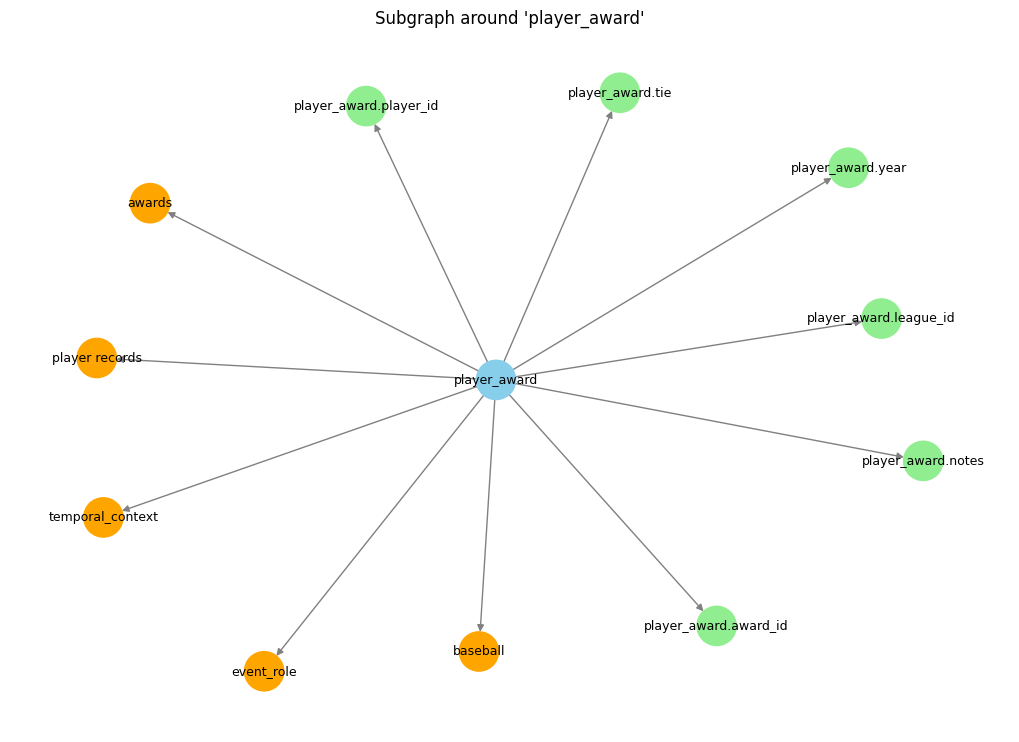

In [11]:
center = "player_award"
neighbors = list(G.neighbors(center)) + [center]
subG = G.subgraph(neighbors)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(subG, k=0.5)
node_colors = ['skyblue' if G.nodes[n]['type']=='table' else 'lightgreen' if G.nodes[n]['type']=='column' else 'orange' for n in subG.nodes()]
nx.draw(subG, pos, with_labels=True, node_color=node_colors, node_size=800, font_size=9, edge_color="gray")
plt.title("Subgraph around 'player_award'")
plt.show()


In [13]:
schema_nodes = []
node_ids = []  # To keep track of node type and key

for table, meta in meta_dict.items():
    # Table node
    table_desc = meta.get('Description', '')
    schema_nodes.append(f"Table: {table}. {table_desc}")
    node_ids.append(('table', table))

    # Column nodes
    for col in meta.get('Columns', []):
        # Get the column description from Ontology if available
        col_desc = ''
        related_cols = meta.get('Ontology', {}).get('related_columns', [])
        for rc in related_cols:
            if rc['column'] == col:
                col_desc = rc['meaning']
                break
        schema_nodes.append(f"Column: {table}.{col}. {col_desc}")
        node_ids.append(('column', f"{table}.{col}"))


In [14]:
!pip install -q sentence-transformers

from sentence_transformers import SentenceTransformer

# Load a small, fast embedding model
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings
embeddings = embedder.encode(schema_nodes, show_progress_bar=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.3 MB/s eta 0:00:00


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
table_to_emb = {t: emb for t, emb in zip(schema_nodes, embeddings)}

In [32]:
import numpy as np

def get_nlq_embedding(nlq, embedder):
    return embedder.encode([nlq])[0]

def get_top_tables(nlq, embedder, table_to_emb, top_n=5, threshold=0.3):
    nlq_emb = get_nlq_embedding(nlq, embedder)
    scored = []
    for table, emb in table_to_emb.items():
        sim = np.dot(nlq_emb, emb) / (np.linalg.norm(nlq_emb) * np.linalg.norm(emb))
        scored.append((table, sim))
    # Sort by similarity
    scored.sort(key=lambda x: x[1], reverse=True)
    return [t for t, s in scored if s >= threshold][:top_n]


In [31]:
# When building table_to_emb, use clean_table_name:
#table_to_emb = {clean_table_name(t): emb for t, emb in zip(schema_nodes, embeddings)}

# When expanding via graph:
def expand_tables_with_graph(tables, meta_dict):
    expanded = set()
    for t in tables:
        t_clean = clean_table_name(t)
        if t_clean not in meta_dict:
            print(f"⚠️ Table '{t}' not in meta_dict. Skipping.")
            continue
        rels = meta_dict[t_clean].get('Ontology', {}).get('relationships', [])
        expanded.add(t_clean)
        for rel in rels:
            tgt = rel.get('to_table')
            if tgt and tgt in meta_dict:
                expanded.add(tgt)
    return list(expanded)


In [27]:
def build_llm_prompt(nlq, relevant_tables, meta_dict):
    prompt = f"NLQ: {nlq}\n\nRelevant Tables & Context:\n"
    for t in relevant_tables:
        desc = meta_dict[t].get('Description', '')
        cols = meta_dict[t].get('Columns', [])
        prompt += f"- {t}: {desc}\n  Columns: {', '.join(cols)}\n"
        # Optionally add one example from table
        if 'Examples' in meta_dict[t] and meta_dict[t]['Examples']:
            ex = meta_dict[t]['Examples'][0]
            prompt += f"  Example NLQ: {ex.get('NLQ','')}\n"
            prompt += f"  Example SQL: {ex.get('SQL','')}\n"
    prompt += "\nGenerate the most accurate SQL query for the NLQ using the context above."
    return prompt


In [33]:
def auto_prompt_for_nlq(nlq, embedder, table_to_emb, meta_dict, top_n=5, threshold=0.3):
    rel_tables = get_top_tables(nlq, embedder, table_to_emb, top_n, threshold)
    rel_tables = expand_tables_with_graph(rel_tables, meta_dict)
    prompt = build_llm_prompt(nlq, rel_tables, meta_dict)
    return prompt

In [30]:
def clean_table_name(table_str):
    # Remove common prefixes/suffixes and whitespace
    t = table_str.lower().replace("table:", "").replace(".", "").strip()
    return t


In [34]:
nlq = "List players who were inducted into the Hall of Fame and also received at least one MVP award."
prompt = auto_prompt_for_nlq(nlq, embedder, table_to_emb, meta_dict)
print(prompt)


NLQ: List players who were inducted into the Hall of Fame and also received at least one MVP award.

Relevant Tables & Context:
- fielding_postseason: 
  Columns: 
- player_award: 
  Columns: 
- player_college: 
  Columns: 
- player_award_vote: 
  Columns: 
- hall_of_fame: 
  Columns: 

Generate the most accurate SQL query for the NLQ using the context above.


In [15]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def find_similar_nodes(query, k=5):
    q_emb = embedder.encode([query])
    sims = cosine_similarity(q_emb, embeddings)[0]
    topk_idx = np.argsort(sims)[::-1][:k]
    return [(node_ids[i], schema_nodes[i], sims[i]) for i in topk_idx]

# Example usage:
query = "Which teams won the World Series?"
results = find_similar_nodes(query)
for node, text, score in results:
    print(f"{node} | {score:.3f}\n  {text}\n")


('table', 'pitching_postseason') | 0.457
  Table: pitching_postseason. 

('table', 'batting_postseason') | 0.445
  Table: batting_postseason. 

('table', 'fielding_postseason') | 0.418
  Table: fielding_postseason. 

('table', 'postseason') | 0.374
  Table: postseason. 

('table', 'team_franchise') | 0.316
  Table: team_franchise. 



In [16]:
def build_llm_prompt(nlq, relevant_tables, meta_dict):
    """
    nlq: str, the user's natural language query
    relevant_tables: list of table names (str) relevant to the NLQ
    meta_dict: dict, the full meta_dict loaded from your YAML schema
    Returns: str, the prompt
    """
    prompt_lines = []
    prompt_lines.append("## Database: Baseball\n")
    prompt_lines.append(f"### User Query\n{nlq}\n")
    prompt_lines.append("### Relevant Tables & Columns\n")

    # 1. Relevant tables and columns
    for table in relevant_tables:
        table_meta = meta_dict.get(table, {})
        columns = table_meta.get("Columns", [])
        col_descs = []
        for col in columns:
            desc = ""
            # try both lower and original keys for column description
            rel_col = next((c for c in table_meta.get("Ontology", {}).get("related_columns", []) if c["column"].lower() == col.lower()), None)
            if rel_col:
                desc = rel_col.get("meaning", "")
            col_descs.append(f"- **{col}**: {desc}")
        prompt_lines.append(f"#### {table}")
        prompt_lines.extend(col_descs)
        prompt_lines.append("")

    # 2. Table Descriptions
    prompt_lines.append("### Table Descriptions\n")
    for table in relevant_tables:
        desc = meta_dict.get(table, {}).get("Description", "")
        prompt_lines.append(f"- **{table}**: {desc}")
    prompt_lines.append("")

    # 3. Table Relationships/Ontology
    prompt_lines.append("### Table Relationships (Ontology Excerpt)")
    for table in relevant_tables:
        ontology = meta_dict.get(table, {}).get("Ontology", {})
        rels = ontology.get("relationships", [])
        for rel in rels:
            src = rel.get("from_col", "")
            tgt_table = rel.get("to_table", "")
            tgt_col = rel.get("to_col", "")
            rel_name = rel.get("name", "")
            if tgt_table and tgt_col:
                prompt_lines.append(f"- `{table}.{src}` → `{tgt_table}.{tgt_col}` ({rel_name})")
    prompt_lines.append("")

    # 4. NLQ/SQL Examples (first 2 per table if present)
    prompt_lines.append("### Example NLQ/SQL Pairs")
    for table in relevant_tables:
        exs = meta_dict.get(table, {}).get("Examples", [])
        for ex in exs[:2]:
            prompt_lines.append(f"#### {table}\n- NLQ: {ex['NLQ']}\n  SQL: {ex['SQL']}")
    prompt_lines.append("")

    # 5. Instructions (general)
    prompt_lines.append("### Instructions\n")
    prompt_lines.append("Based on the above schema and relationships, generate an SQL query that answers the user's natural language question. Return only the SQL query.")

    return "\n".join(prompt_lines)


In [17]:
import numpy as np

# Assume: embeddings_dict is {table_name: embedding_vector}
# nlq_embedding is the vector for the new NLQ

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def get_top_tables(nlq_embedding, embeddings_dict, top_n=5, threshold=0.3):
    scored = []
    for table, vec in embeddings_dict.items():
        sim = cosine_similarity(nlq_embedding, vec)
        scored.append((table, sim))
    # Sort by similarity
    scored.sort(key=lambda x: x[1], reverse=True)
    # Filter by threshold or take top N
    return [table for table, sim in scored if sim >= threshold][:top_n]


In [18]:
def expand_tables_with_graph(tables, meta_dict):
    expanded = set(tables)
    for t in tables:
        rels = meta_dict[t].get('Ontology', {}).get('relationships', [])
        for rel in rels:
            tgt = rel.get('to_table')
            if tgt and tgt in meta_dict:
                expanded.add(tgt)
    return list(expanded)


In [22]:
def auto_prompt_for_nlq(nlq, meta_dict, table_embeddings, top_n=5, threshold=0.3):
    rel_tables = get_top_tables(nlq, table_embeddings, top_n, threshold)
    rel_tables = expand_tables_with_graph(rel_tables, meta_dict)
    prompt = build_llm_prompt(nlq, rel_tables, meta_dict)
    return prompt


In [23]:
nlq_examples = [
    "List players who were inducted into the Hall of Fame and also received at least one MVP award.",
    "Which teams won the World Series in the last 10 years, along with their managers’ names and the total attendance for their home games?",
    "Find players who played for both the Yankees and Red Sox and had more than 30 home runs in any regular season.",
    "Show the colleges that produced the highest number of players who later managed a World Series winning team.",
    "Who are the players that have played both as a catcher and as a pitcher in postseason games, and what are their respective stats?"
]

for i, q in enumerate(nlq_examples, 1):
    print(f"\n=== Prompt Example #{i} ===")
    prompt = auto_prompt_for_nlq(q, meta_dict, embeddings)
    print(prompt)
    print("-" * 100)



=== Prompt Example #1 ===


AttributeError: 'numpy.ndarray' object has no attribute 'items'